# Water Quality at the Barton Spring

![The main barton spring. To the left there is a white rock face, and to the right the rock meets the clear green-blue water.](barton-spring.jpg)

Finding a dataset for this project was pretty difficult considering it required at least four sets of numeric values: three predictors and one predicted. After a lot of searching, I found another City of Austin environmental dataset. This one is about water quality measurments throughout the city. The raw data consists of approximately 1.5 million measurments recorded from 1947 to the present day.

To narrow in on the data, I decided to focus on just one location: the main spring at Barton Springs. Furthermore, I chose the most commonly recorded factors: dissolved oxygen, turbidity, pH and water temperature. After some research, I found that turbidity, pH, and water temperature all have bearing on dissolved oxygen. Thus, my goal for this project was to create a model in which the three aforementioned factors can help predict dissolved oxygen.

## Gathering the data

In [1]:
import arviz as az
import bambi as bmb
from dataclasses import dataclass
import datetime
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

I used queries on the City of Austin Open Data interface to extract just the rows taken at Barton Spring and with the parameters we want to look at. That ended up being 3,340 rows:

In [2]:
# Reading in the raw data
raw = pd.read_csv("water-quality-data.csv"); raw

,DATA_REF_NO,SAMPLE_REF_NO,PROJECT,WATERSHED,SITE_TYPE,SAMPLE_SITE_NO,SITE_NAME,LAT_DD_WGS84,LON_DD_WGS84,SAMPLE_DATE,...,DEPTH_IN_METERS,PARAM_TYPE,PARAMETER,QC_TYPE,QUALIFIER,RESULT,UNIT,QC_FLAG,METHOD,FILTER
0,3027306,596883,Barton Springs TPDES,Barton Creek,Spring,35,Barton Spring,30.263535,-97.77098,01/08/2025 09:45:00 AM,...,NaN,Clarity,TURBIDITY,NaN,NaN,0.73,NTU,NaN,In-Situ Aqua Troll,Total
1,3027431,596883,Barton Springs TPDES,Barton Creek,Spring,35,Barton Spring,30.263535,-97.77098,01/08/2025 09:45:00 AM,...,NaN,Oxygen,DISSOLVED OXYGEN,NaN,NaN,4.29,MG/L,NaN,In-Situ Aqua Troll,Dissolved
2,3027400,596883,Barton Springs TPDES,Barton Creek,Spring,35,Barton Spring,30.263535,-97.77098,01/08/2025 09:45:00 AM,...,NaN,Alkalinity/Hardness/pH,PH,NaN,NaN,6.98,Standard units,NaN,In-Situ Aqua Troll,Total
3,3027473,596883,Barton Springs TPDES,Barton Creek,Spring,35,Barton Spring,30.263535,-97.77098,01/08/2025 09:45:00 AM,...,NaN,Conventionals,WATER TEMPERATURE,NaN,NaN,21.97,Deg. Celsius,NaN,In-Situ Aqua Troll,Total
4,3024943,596753,Barton Springs TPDES,Barton Creek,Spring,35,Barton Spring,30.263535,-97.77098,12/11/2024 10:45:00 AM,...,NaN,Alkalinity/Hardness/pH,PH,NaN,NaN,7.24,Standard units,NaN,In-Situ Aqua Troll,Total
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3336,438735,65792,Groundwater,Barton Creek,Spring,35,Barton Spring,30.263535,-97.77098,06/01/1991 12:00:00 AM,...,NaN,Clarity,TURBIDITY,NaN,NaN,0.71,NTU,U,HACH,Total
3337,363040,26802,Groundwater,Barton Creek,Spring,35,Barton Spring,30.263535,-97.77098,05/06/1991 12:00:00 AM,...,NaN,Alkalinity/Hardness/pH,PH,NaN,NaN,7.40,Standard units,U,UNKNOWN,Total
3338,2387521,479314,Water Watch Dog,Barton Creek,Spring,35,Barton Spring,30.263535,-97.77098,07/06/1990 12:00:00 AM,...,NaN,Alkalinity/Hardness/pH,PH,NaN,NaN,7.12,Standard units,U,UNKNOWN,Total
3339,2387524,479314,Water Watch Dog,Barton Creek,Spring,35,Barton Spring,30.263535,-97.77098,07/06/1990 12:00:00 AM,...,NaN,Conventionals,WATER TEMPERATURE,NaN,NaN,22.73,Deg. Celsius,U,THERMOMETER (ALCOHOL),Total


Importantly, in the raw data, each row represents only one measurement at a specific date and time. Thus, I had to merge water quality parameters by date to produce a clean dataset for analysis.

In [3]:
# A dataclass is a structure composed of multiple variables that
# are grouped together.
@dataclass
class Measurement:
    # Date of the measurement
    date: datetime.date | None
    # Turbidity ("murkiness")
    turbidity: np.float64 | None
    # Dissolved oxygen (quantity of oxygen in the water)
    dissolved_oxygen: np.float64 | None
    # pH
    ph: np.float64 | None
    # Water temperature (celsius)
    water_temp: np.float64 | None

In [4]:
data = {}

# Go through each row in the raw data
for i, row in raw.iterrows():
    # Parse date
    month, day, year = [int(i) for i in row["SAMPLE_DATE"][:10].split("/")]
    date = datetime.date(year, month, day)

    # Find if a row in the cleaned data with this date exists
    if date in data:
        measurement = data[date]
    else:
        # ... and if not, make such a row:
        measurement = Measurement(date=date, turbidity=None, dissolved_oxygen=None, ph=None, water_temp=None)
        data[date] = measurement

    # Parse predictors
    param = row["PARAMETER"]
    value = np.float64(row["RESULT"])
    
    if param == "TURBIDITY":
        measurement.turbidity = value
    elif param == "DISSOLVED OXYGEN":
        measurement.dissolved_oxygen = value
    elif param == "PH":
        measurement.ph = value
    elif param == "WATER TEMPERATURE":
        measurement.water_temp = value

# Remove rows with missing data
data = list(data.values())
data = [row for row in data if None not in (row.turbidity, row.dissolved_oxygen, row.ph, row.water_temp)]

print(f"Data points: {len(data)}")

Data points: 259


Out of all the data we had originally, it turns out there were only 259 days where measurements of all the required factors were made, and only 258 contained useful data:

In [5]:
df = pd.DataFrame(data)

# There is a row in the data that has a dissolved oxygen value of around 60. I dropped
# rows with weird values because the data is raw and such outliers are most definitely
# errors.
df = df[df.dissolved_oxygen <= 10]

df

,date,turbidity,dissolved_oxygen,ph,water_temp
0,2025-01-08,0.73,4.29,6.98,21.97
1,2024-11-13,0.40,4.16,7.16,21.92
2,2024-10-09,1.84,4.53,7.11,21.90
3,2024-09-11,2.24,4.57,7.38,21.84
4,2024-05-22,0.00,5.37,7.19,21.61
...,...,...,...,...,...
254,1992-12-21,1.30,6.60,7.20,20.40
255,1992-06-04,1.90,6.50,7.90,20.50
256,1991-10-11,3.00,10.00,7.90,22.00
257,1991-08-02,0.80,9.00,7.60,23.00


Now that the dataset had only variables that we care about, and they were now linked by date, I proceeded to analyze the data.

## Variables

### Dissolved oxygen

Dissolved oxygen is the ratio of the mass of the oxygen molecules in the water to its volume, expressed in miligrams per liter (mg/L). I chose dissolved oxygen because there are many factors that affect it:

![A diagram showing the dissolved oxygen cycle underwater, presented as a cutaway of the ocean floor featuring dirt, fish, and phytoplankton.](dissolved_oxygen_cycle.png)

### Turbidity

According to the Meadowlands Underwater Research Institute, "oxygen is more easily dissolved in water with low levels of dissolved or suspended solids." Turbidity, or the murkiness of water, is a measure of solids in water. Turbidity is measured in Nephelometric Turbidity Units (NTU).

### pH

pH is a measure of the acidity of water, and is important for influencing the presence of aquatic life in water. It is typically expressed as a value from 1 to 14, with lower values indicating greater acidity.

### Water temperature

Water temperature is an important indicator because oxygen dissolves in cold water more easily than in warm water.

### DAG

I started out by creating a diagram of relationships between my main variables, as well as secondary variables that exist in real life. These are the main relationships:

- Temperature affects dissolved oxygen directly as a result of chemical interactions.
- pH doesn't affect dissolved oxygen directly. However, it directly affects the presence of aquatic life.
- Turbidity is really a measure of dissolved solids in water. Thus, it is actually affected by dissolved and suspendend solids, which also affect dissolved oxygen due to chemistry.
- Aquatic plants produce oxygen, while aquatic animals use it. Thus, aquatic life directly affects dissolved oxygen. Also, aquatic life affects the turbidity of water (things like algae make water murkier). However, aquatic life is not easy to quantify and is not a parameter in our dataset.

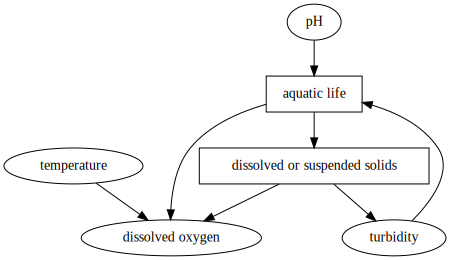

In [6]:
dag1 = graphviz.Digraph("cplx-dag", comment="DAG representing the relationship between water quality parameters")

dag1.node("D", "dissolved oxygen")
dag1.node("T", "turbidity")
dag1.node("M", "temperature")
dag1.node("P", "pH")
dag1.node("a", "aquatic life", shape="rect")
dag1.node("s", "dissolved or suspended solids", shape="rect")

dag1.edges(["MD", "aD", "Pa", "as", "sD", "sT", "Ta"])
dag1

For the sake of the model, I had to create a DAG with just the variables I had data on. Given the relationships I talked about above, I removed aquatic life and dissolved or suspended solids. The main thing to consider is that while all variables essentially directly affect dissolved oxygen, there is also an interaction between turbidy in pH through secondary variables.

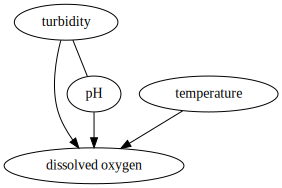

In [7]:
dag2 = graphviz.Digraph("simple-dag", comment="DAG representing a simplified relationship between water quality parameters")

dag2.node("D", "dissolved oxygen")
dag2.node("T", "turbidity")
dag2.node("M", "temperature")
dag2.node("P", "pH")

dag2.edges(["TD", "MD", "PD"])
dag2.edge("T", "P", arrowhead="none")

dag2

## Assumptions

I know very little about the distributions of our priors. I am neither a water quality expert, nor a Barton Springs expert. Thus, I let Bambi to choose priors based on the data.

As for the likelihood, a Negative Binomial distribution would suffice. According to Wikipedia, "Negative binomial modeling is widely employed in ecology and biodiversity research for analyzing count data where overdispersion is very common."

## Models

I ended up creating three models, all based on the DAG I created earlier.

In [8]:
def plot_model(model, idata):
    """Plots a model by individually plotting each predictor against dissolved oxygen."""
    # Create 3 plots arranged horizontally
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 5))

    # Suppress warnings that we can't fix
    with warnings.catch_warnings(action="ignore"):
        # Plot turbidity
        bmb.interpret.plot_predictions(model, idata, "turbidity", ax=ax0)
        ax0.plot(df.turbidity, df.dissolved_oxygen, "C2.", zorder=-3)

        # Plot pH
        bmb.interpret.plot_predictions(model, idata, "ph", ax=ax1)
        ax1.plot(df.ph, df.dissolved_oxygen, "C2.", zorder=-3)

        # Plot water temperature
        bmb.interpret.plot_predictions(model, idata, "water_temp", ax=ax2)
        ax2.plot(df.water_temp, df.dissolved_oxygen, "C2.", zorder=-3)

### Model 1: All variables and relationships

The first model is the fullest representation of the relationship I believe are present based on my research. It models all three priors, as well as an interaction between turbidity and pH.

In [9]:
model1 = bmb.Model("dissolved_oxygen ~ water_temp + turbidity + ph + turbidity:ph", df, family="negativebinomial")
idata_model1 = model1.fit(idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, water_temp, turbidity, ph, turbidity:ph]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [Intercept, alpha, ph, turbidity, turbidity:ph, water_temp]


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'water_temp'}>],
       [<Axes: title={'center': 'turbidity'}>,
        <Axes: title={'center': 'ph'}>,
        <Axes: title={'center': 'turbidity:ph'}>]], dtype=object)

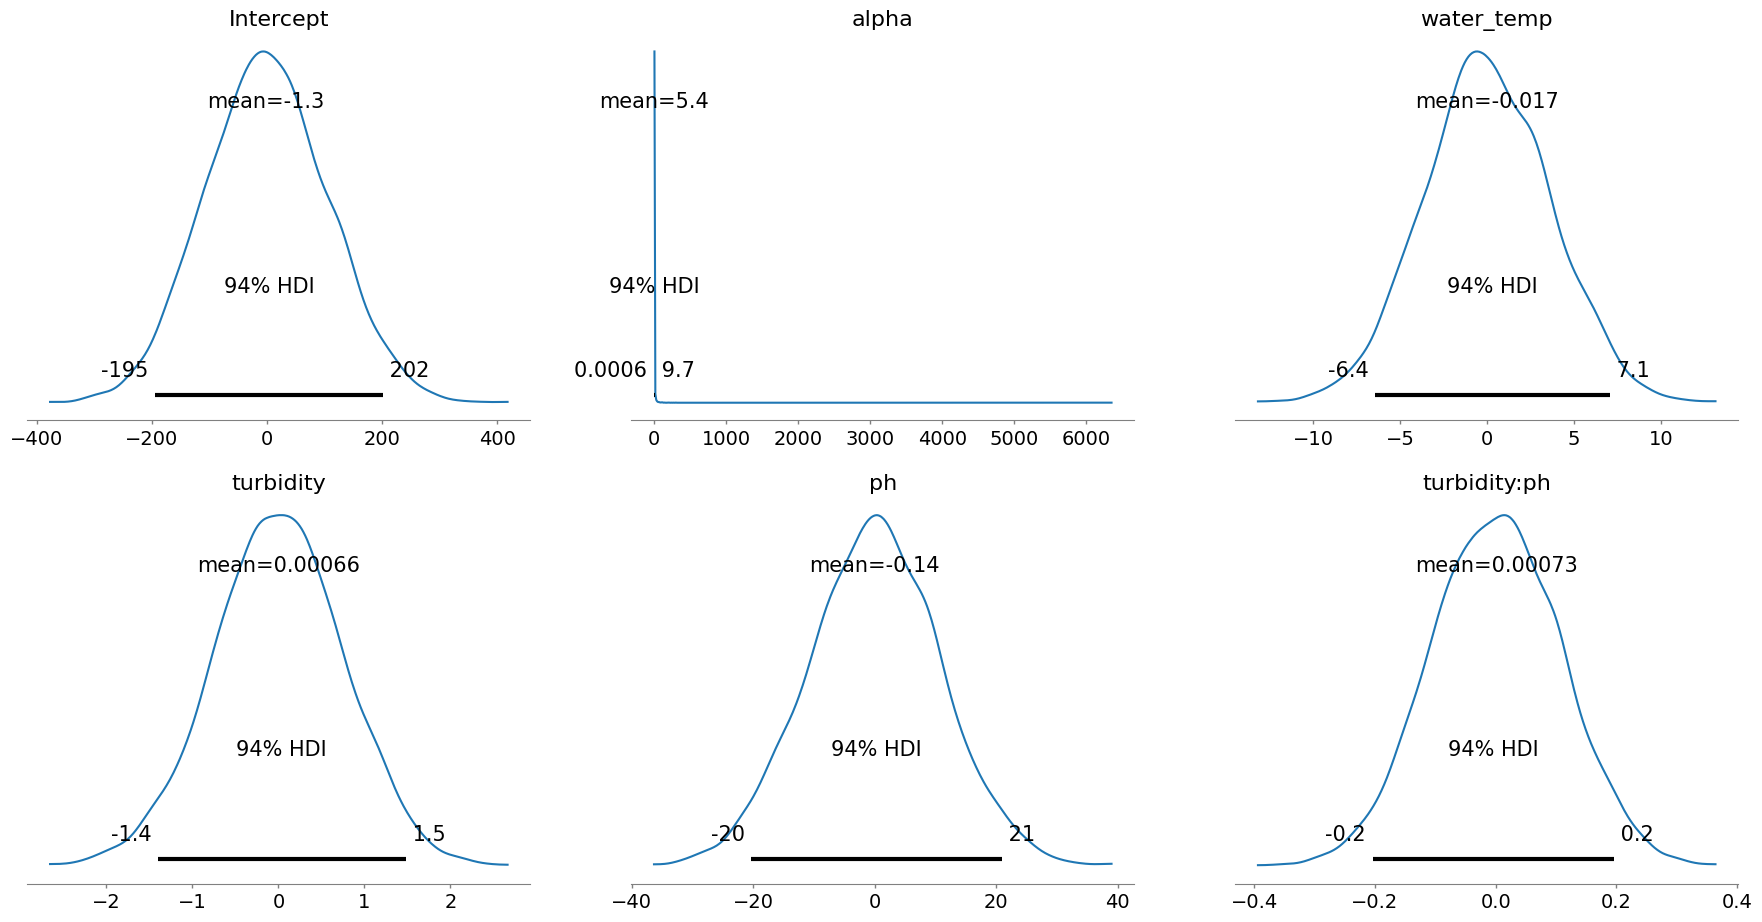

In [10]:
model1.plot_priors()

The priors were chosen by Bambi and look reasonable. To see how well the model works, I can use my plotting function:

Default computed for conditional variable: turbidity
Default computed for unspecified variable: ph, water_temp
Default computed for conditional variable: ph
Default computed for unspecified variable: turbidity, water_temp
Default computed for conditional variable: water_temp
Default computed for unspecified variable: ph, turbidity


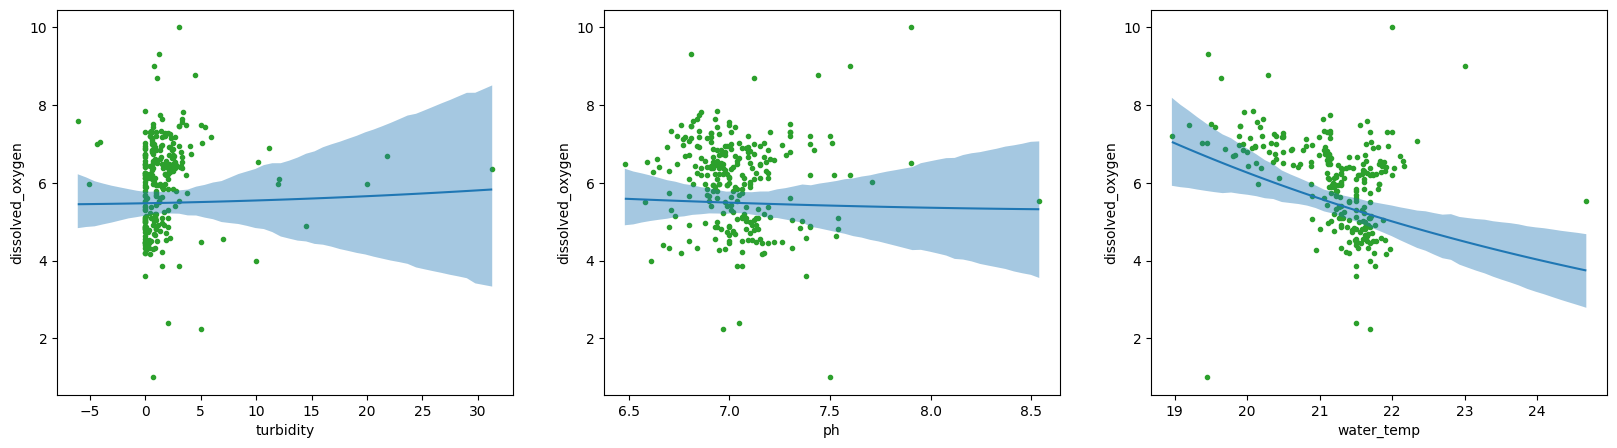

In [11]:
plot_model(model1, idata_model1)

The graphs show the model's predictions based on each predictor.

- Turbidity is generally between -1 to 5, and dissolved oxygen seems to loosely related if we don't consider other variables. In general, the model does a good job of finding the average turbidity and assigning more uncertainty where we don't have as much data.
- pH and dissolved oxygen seem to have a horizontally sloping relationship which is modeled pretty well.
- The negative, slightly curving, slope between dissolved oxygen and water temperature is modeled well. However, the line seems to be below where most of the data lies between a temperature of 19 and 21.

### Model 2: All variables without interactions

Secondly, I tried doing the same model as 1, but without the interaction. I thought that maybe it was unnecessary, since a simple model is sometimes better than something more complex if it models just as well.

In [12]:
model2 = bmb.Model("dissolved_oxygen ~ water_temp + turbidity + ph", df, family="negativebinomial")
idata_model2 = model2.fit(idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, water_temp, turbidity, ph]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Default computed for conditional variable: turbidity
Default computed for unspecified variable: ph, water_temp
Default computed for conditional variable: ph
Default computed for unspecified variable: turbidity, water_temp
Default computed for conditional variable: water_temp
Default computed for unspecified variable: ph, turbidity


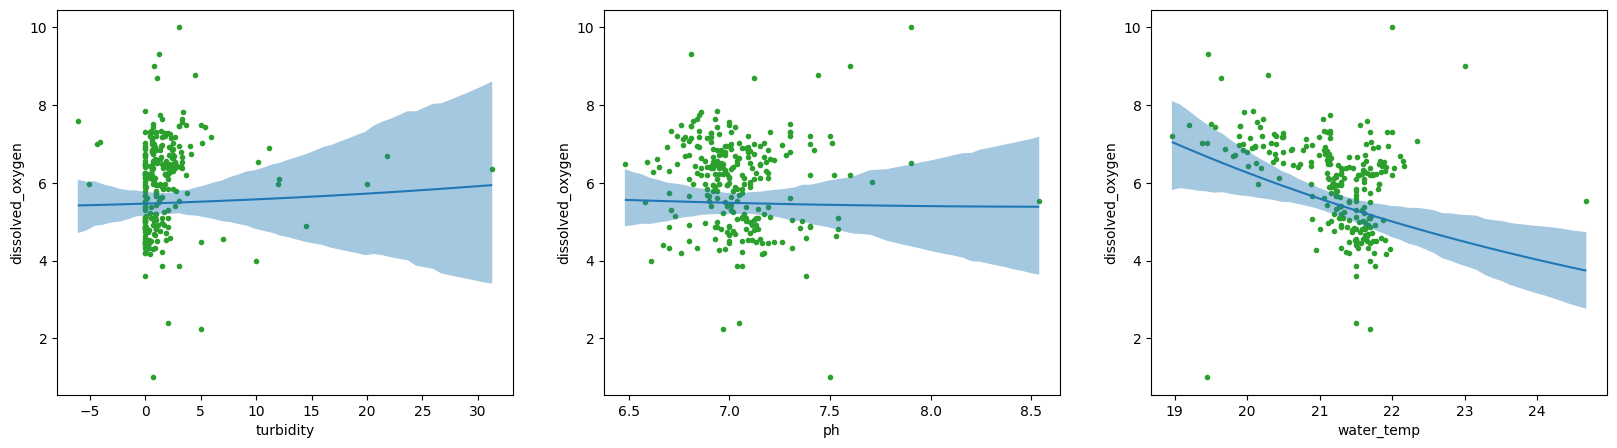

In [13]:
plot_model(model2, idata_model2)

The same relationships are shown as before. The graphs are nearly identical to Model 1. We would probably need `elpd_loo` to better compare the two models.

### Model 3: Just turbidity and pH with an interaction

In this model, I eliminated `water_temp` as a predictor altogether, focusing on just the turbidity-pH relationship.

In [14]:
model3 = bmb.Model("dissolved_oxygen ~ turbidity + ph + turbidity:ph", df, family="negativebinomial")
idata_model3 = model3.fit(idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, turbidity, ph, turbidity:ph]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


Default computed for conditional variable: turbidity
Default computed for unspecified variable: ph
Default computed for conditional variable: ph
Default computed for unspecified variable: turbidity
Default computed for conditional variable: water_temp
Default computed for unspecified variable: ph, turbidity


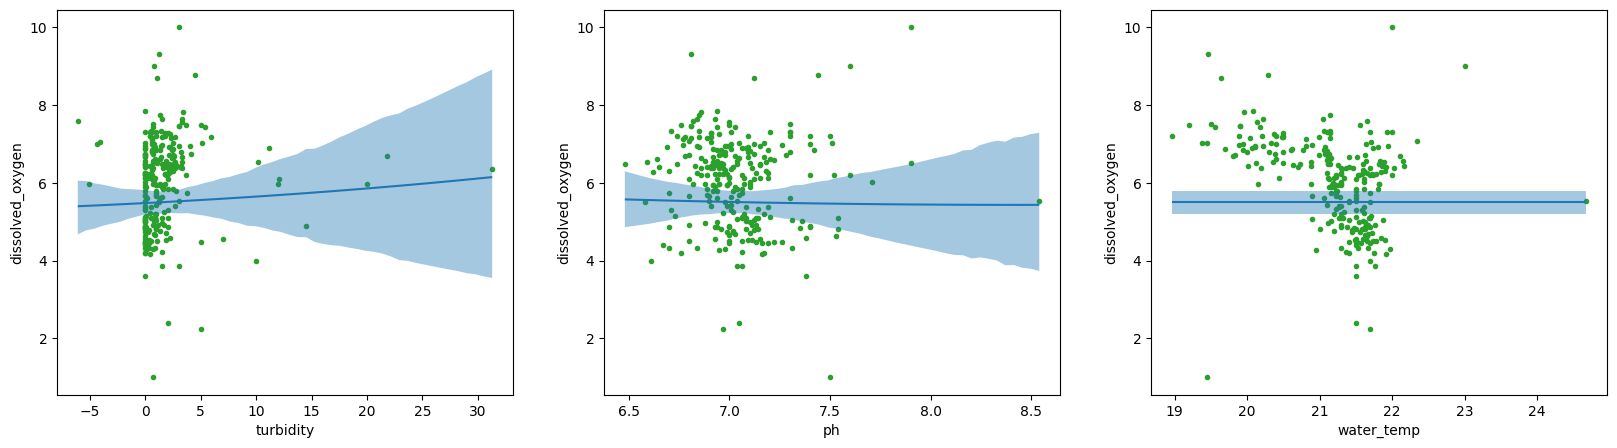

In [15]:
plot_model(model3, idata_model3)

It is once again quite hard to tell the difference between this and the previous mdoels from the graphs alone. Most notably, the model doesn't show the slope or variance relationship between `water_temp` and `dissolved_oxygen` now that I eliminated `water_temp` for this model.

### Comparison

In [16]:
az.compare({"Model 1": idata_model1,
            "Model 2": idata_model2,
            "Model 3": idata_model3})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Model 2,0,-492.147362,1.484602,0.000000,1.000000e+00,4.810671,0.000000,False,log
Model 1,1,-492.707536,1.830613,0.560173,2.775558e-17,4.871060,0.217569,False,log
Model 3,2,-496.316395,1.401438,4.169032,0.000000e+00,3.848181,1.951757,False,log


The comparison shows that by the `elpd_loo` metric, Model 2 is slightly better than model 1, and both are significantly better than Model 3.

## Conclusion

Models 1 and 2 both include all three variables, with the difference being the interaction. All variables are relevant to dissolved oxygen, as my research had indicated. The issue with model 3 is that temperature turns out to be a very good predictor of dissolved oxygen due to the direct chemical relationship. I think that's why `elpd_loo` was lower for it.

I would argue that Model 2 is the best model given this data because it focuses on the most important relationships. Yes, it doesn't have the pH-turbidity interaction, but that interaction is obscured by at least two variables we can't measure given this dataset (as shown in the DAG). Our `elpd_loo` metric further confirms that this interaction might be confusing the model more than it is helping.

The City of Austin dataset actually has a _lot_ more measurements. It's possible that I could have included other variables that would produce a better model. However, I am happy with how my model turned out.

## Sources

- https://data.austintexas.gov/Environment/Water-Quality-Sampling-Data/5tye-7ray/about_data
- https://meri.njmeadowlands.gov/downloads/typical_water_quality_parameters.pdf
- https://physics.stackexchange.com/questions/311409/why-do-most-gases-dissolve-easier-at-colder-temperatures
- https://atlas-scientific.com/blog/does-dissolved-oxygen-affect-ph/
- https://en.wikipedia.org/wiki/Turbidity
- https://en.wikipedia.org/wiki/Negative_binomial_distribution#Waiting_time_in_a_Bernoulli_process